# Imports

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm.auto import tqdm
from glob import glob
import time, gc
import cv2

from tensorflow import keras
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import clone_model
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, Callback, ModelCheckpoint
from keras import backend as K
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont
from matplotlib import pyplot as plt
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


/kaggle/input/bengaliai-cv19/train.csv
/kaggle/input/bengaliai-cv19/train_image_data_2.parquet
/kaggle/input/bengaliai-cv19/test_image_data_1.parquet
/kaggle/input/bengaliai-cv19/class_map.csv
/kaggle/input/bengaliai-cv19/train_multi_diacritics.csv
/kaggle/input/bengaliai-cv19/train_image_data_3.parquet
/kaggle/input/bengaliai-cv19/test_image_data_2.parquet
/kaggle/input/bengaliai-cv19/train_image_data_1.parquet
/kaggle/input/bengaliai-cv19/test_image_data_0.parquet
/kaggle/input/bengaliai-cv19/test.csv
/kaggle/input/bengaliai-cv19/class_map_corrected.csv
/kaggle/input/bengaliai-cv19/train_image_data_0.parquet
/kaggle/input/bengaliai-cv19/sample_submission.csv
/kaggle/input/bengaliai-cv19/test_image_data_3.parquet
/kaggle/input/kalpurush-fonts/kalpurush-2.ttf


# Data

In [2]:
train_df_ = pd.read_csv('/kaggle/input/bengaliai-cv19/train.csv')
test_df_ = pd.read_csv('/kaggle/input/bengaliai-cv19/test.csv')
class_map_df = pd.read_csv('/kaggle/input/bengaliai-cv19/class_map.csv')
sample_sub_df = pd.read_csv('/kaggle/input/bengaliai-cv19/sample_submission.csv')

In [3]:
train_df_.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


In [4]:
test_df_.head()

,row_id,image_id,component
0,Test_0_consonant_diacritic,Test_0,consonant_diacritic
1,Test_0_grapheme_root,Test_0,grapheme_root
2,Test_0_vowel_diacritic,Test_0,vowel_diacritic
3,Test_1_consonant_diacritic,Test_1,consonant_diacritic
4,Test_1_grapheme_root,Test_1,grapheme_root


In [5]:
sample_sub_df.head()

,row_id,target
0,Test_0_consonant_diacritic,0
1,Test_0_grapheme_root,0
2,Test_0_vowel_diacritic,0
3,Test_1_consonant_diacritic,0
4,Test_1_grapheme_root,0


In [6]:
class_map_df.head()

,component_type,label,component
0,grapheme_root,0,ং
1,grapheme_root,1,ঃ
2,grapheme_root,2,অ
3,grapheme_root,3,আ
4,grapheme_root,4,ই


In [7]:
print(f'Size of training data: {train_df_.shape}')
print(f'Size of test data: {test_df_.shape}')
print(f'Size of class map: {class_map_df.shape}')

Size of training data: (200840, 5)
Size of test data: (36, 3)
Size of class map: (186, 3)


# Frequency Plot

In [8]:
plot_df = train_df_[['grapheme_root','vowel_diacritic', 'consonant_diacritic']]

In [9]:
unique_row_counts = plot_df.groupby(['grapheme_root','vowel_diacritic', 'consonant_diacritic']).size().reset_index(name='Count')

In [10]:
unique_row_counts = unique_row_counts.sort_values(by=['Count'], ascending=False).reset_index(drop=True)

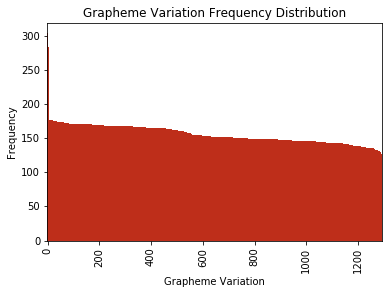

In [11]:
plot = unique_row_counts.plot(kind='bar', y='Count', color='#be2e1a', title='Grapheme Variation Frequency Distribution', width=2)
plot.set_xlabel("Grapheme Variation")
plot.set_ylabel("Frequency")
plot.set_xticks([0, 200, 400, 600, 800, 1000, 1200])
plot.set_xticklabels([0, 200, 400, 600, 800, 1000, 1200])
plot.get_legend().remove()
fig = plot.get_figure()
fig.savefig("output.png", dpi=300, bbox_inches='tight')

# Data Augmentation

In [12]:
train_df_ = train_df_.drop(['grapheme'], axis=1, inplace=False)

In [13]:
train_df_[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']] = train_df_[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].astype('uint8')

In [14]:
IMG_SIZE=64
N_CHANNELS=1

In [15]:
def resize(df, size=64, need_progress_bar=True):
    resized = {}
    resize_size=64
    if need_progress_bar:
        for i in tqdm(range(df.shape[0])):
            image=df.loc[df.index[i]].values.reshape(137,236)
            _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

            idx = 0 
            ls_xmin = []
            ls_ymin = []
            ls_xmax = []
            ls_ymax = []
            for cnt in contours:
                idx += 1
                x,y,w,h = cv2.boundingRect(cnt)
                ls_xmin.append(x)
                ls_ymin.append(y)
                ls_xmax.append(x + w)
                ls_ymax.append(y + h)
            xmin = min(ls_xmin)
            ymin = min(ls_ymin)
            xmax = max(ls_xmax)
            ymax = max(ls_ymax)

            roi = image[ymin:ymax,xmin:xmax]
            resized_roi = cv2.resize(roi, (resize_size, resize_size),interpolation=cv2.INTER_AREA)
            resized[df.index[i]] = resized_roi.reshape(-1)
    else:
        for i in range(df.shape[0]):
            #image = cv2.resize(df.loc[df.index[i]].values.reshape(137,236),(size,size),None,fx=0.5,fy=0.5,interpolation=cv2.INTER_AREA)
            image=df.loc[df.index[i]].values.reshape(137,236)
            _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

            idx = 0 
            ls_xmin = []
            ls_ymin = []
            ls_xmax = []
            ls_ymax = []
            for cnt in contours:
                idx += 1
                x,y,w,h = cv2.boundingRect(cnt)
                ls_xmin.append(x)
                ls_ymin.append(y)
                ls_xmax.append(x + w)
                ls_ymax.append(y + h)
            xmin = min(ls_xmin)
            ymin = min(ls_ymin)
            xmax = max(ls_xmax)
            ymax = max(ls_ymax)

            roi = image[ymin:ymax,xmin:xmax]
            resized_roi = cv2.resize(roi, (resize_size, resize_size),interpolation=cv2.INTER_AREA)
            resized[df.index[i]] = resized_roi.reshape(-1)
    resized = pd.DataFrame(resized).T
    return resized

In [16]:
def get_dummies(df):
    cols = []
    for col in df:
        cols.append(pd.get_dummies(df[col].astype(str)))
    return pd.concat(cols, axis=1)

## Basic Model

In [17]:
inputs = Input(shape = (IMG_SIZE, IMG_SIZE, 1))

model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1))(inputs)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=32, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=64, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=128, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=256, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Flatten()(model)
model = Dense(1024, activation = "relu")(model)
model = Dropout(rate=0.3)(model)
dense = Dense(512, activation = "relu")(model)

head_root = Dense(168, activation = 'softmax')(dense)
head_vowel = Dense(11, activation = 'softmax')(dense)
head_consonant = Dense(7, activation = 'softmax')(dense)

model = Model(inputs=inputs, outputs=[head_root, head_vowel, head_consonant])

In [18]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 64, 64, 32)   9248        conv2d_2[0][0]                   
____________________________________________________________________________________________

Let's visualize the 3-tailed (3 output) CNN by plotting it.

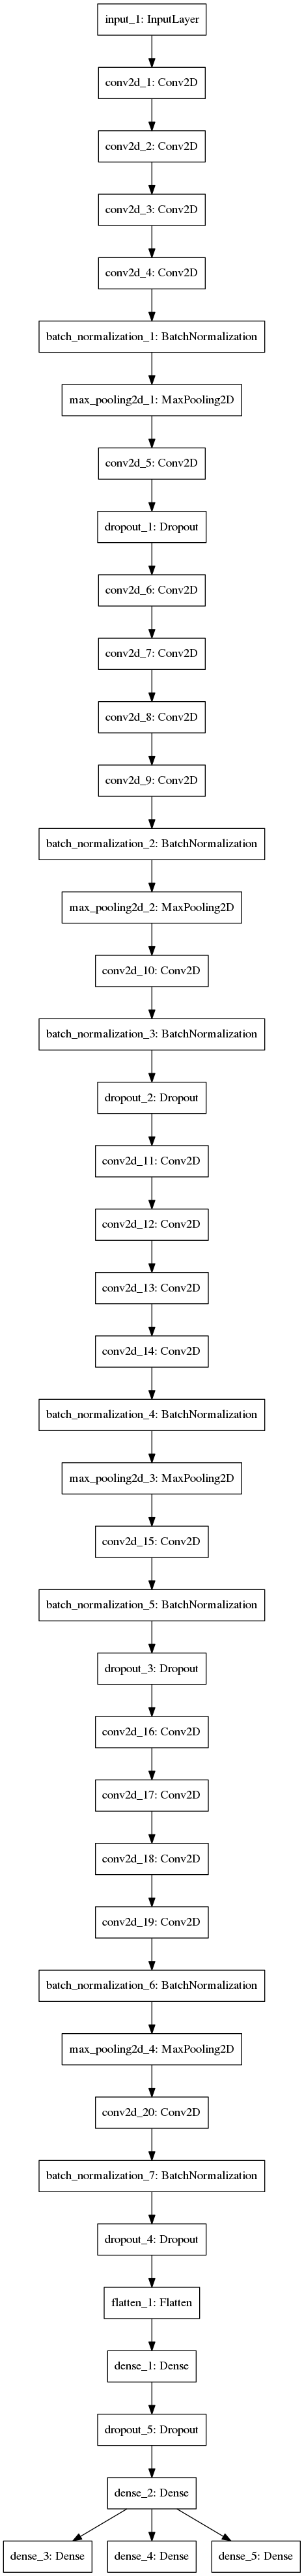

In [19]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [20]:
# CHANGED
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# , keras.metrics.Recall()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'], loss_weights=[0.5, 0.25, 0.25])

In [21]:
batch_size = 256
epochs = 30

In [22]:
class MultiOutputDataGenerator(keras.preprocessing.image.ImageDataGenerator):

    def flow(self,
             x,
             y=None,
             batch_size=32,
             shuffle=True,
             sample_weight=None,
             seed=None,
             save_to_dir=None,
             save_prefix='',
             save_format='png',
             subset=None):

        targets = None
        target_lengths = {}
        ordered_outputs = []
        for output, target in y.items():
            if targets is None:
                targets = target
            else:
                targets = np.concatenate((targets, target), axis=1)
            target_lengths[output] = target.shape[1]
            ordered_outputs.append(output)


        for flowx, flowy in super().flow(x, targets, batch_size=batch_size,
                                         shuffle=shuffle):
            target_dict = {}
            i = 0
            for output in ordered_outputs:
                target_length = target_lengths[output]
                target_dict[output] = flowy[:, i: i + target_length]
                i += target_length

            yield flowx, target_dict

In [23]:
HEIGHT = 137
WIDTH = 236

### CyclicLR


In [24]:
# ADDED
class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency.
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    The amplitude of the cycle can be scaled on a per-iteration or
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each
        cycle iteration.
    For more detail, please see paper.
    # Example for CIFAR-10 w/ batch size 100:
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    # References
      - [Cyclical Learning Rates for Training Neural Networks](
      https://arxiv.org/abs/1506.01186)
    """

    def __init__(
            self,
            base_lr=0.001,
            max_lr=0.006,
            step_size=2000.,
            mode='triangular',
            gamma=1.,
            scale_fn=None,
            scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        if mode not in ['triangular', 'triangular2',
                        'exp_range']:
            raise KeyError("mode must be one of 'triangular', "
                           "'triangular2', or 'exp_range'")
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn is None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1 / (2.**(x - 1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma ** x
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr is not None:
            self.base_lr = new_base_lr
        if new_max_lr is not None:
            self.max_lr = new_max_lr
        if new_step_size is not None:
            self.step_size = new_step_size
        self.clr_iterations = 0.

    def clr(self):
        cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr - self.base_lr) * \
                np.maximum(0, (1 - x)) * self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr - self.base_lr) * \
                np.maximum(0, (1 - x)) * self.scale_fn(self.clr_iterations)

    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())

    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1
        K.set_value(self.model.optimizer.lr, self.clr())

        self.history.setdefault(
            'lr', []).append(
            K.get_value(
                self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

# Class Weigths

In [25]:
train_df_.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic
0,Train_0,15,9,5
1,Train_1,159,0,0
2,Train_2,22,3,5
3,Train_3,53,2,2
4,Train_4,71,9,5


In [26]:
train_grapheme_ = train_df_["grapheme_root"].to_numpy()
train_vowel_ = train_df_["vowel_diacritic"].to_numpy()
train_consonant_ = train_df_["consonant_diacritic"].to_numpy()

In [27]:
class_weights_grapheme_ = class_weight.compute_class_weight('balanced', np.unique(train_grapheme_), train_grapheme_)
class_weights_vowel_ = class_weight.compute_class_weight('balanced', np.unique(train_vowel_), train_vowel_)
class_weights_consonant_ = class_weight.compute_class_weight('balanced', np.unique(train_consonant_), train_consonant_)

In [28]:
print(class_weights_grapheme_)
print(class_weights_vowel_)
print(class_weights_consonant_)

[8.13249109 8.24466338 3.54740709 3.75935909 3.61171055 6.83129252
 3.8814162  7.81356987 7.61449803 2.69251394 7.86497494 7.91706086
 8.18819309 0.22056756 1.50185451 1.10385613 1.27178318 1.57092798
 0.7320736  4.30027407 3.55796485 1.269083   0.40374069 0.23217638
 3.55796485 1.06075971 6.99108883 3.91959407 1.57506744 0.43002741
 2.73564346 1.55660962 1.06075971 8.79026611 4.33143547 2.5115046
 1.16745722 4.1946533  0.35643297 1.93756271 1.57922879 3.91959407
 0.61087184 0.32933228 1.13100869 8.30191799 2.06116585 2.64485883
 0.86880537 3.72422489 1.61988644 3.66710488 1.27858416 0.32397729
 2.01938546 0.71159297 0.44474561 1.88858798 0.93033167 0.51110568
 2.80628214 2.07908903 1.37727672 8.02333014 0.21363048 0.87580673
 1.52096207 2.51679198 1.89457399 1.57922879 1.24919142 0.40717854
 0.20841635 9.1959707  0.78753372 1.06075971 0.61749803 1.24919142
 4.08012352 0.34571318 2.62165831 0.34772431 4.09409654 0.84307207
 2.59886128 0.87709185 0.57090554 7.11592971 1.57299499 0.51685

In [29]:
class_weights_ = [class_weights_grapheme_, class_weights_vowel_, class_weights_consonant_]

### Training loop

In [30]:
# file_path = 'best_model.hdf5'

In [ ]:
# histories = []
# for i in range(4):
#     train_df = pd.merge(pd.read_parquet(f'/kaggle/input/bengaliai-cv19/train_image_data_{i}.parquet'), train_df_, on='image_id').drop(['image_id'], axis=1)
    
#     X_train = train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1)
#     X_train = resize(X_train)/255
    
#     # CNN takes images in shape `(batch_size, h, w, channels)`, so reshape the images
#     X_train = X_train.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    
#     Y_train_root = pd.get_dummies(train_df['grapheme_root']).values
#     Y_train_vowel = pd.get_dummies(train_df['vowel_diacritic']).values
#     Y_train_consonant = pd.get_dummies(train_df['consonant_diacritic']).values

#     print(f'Training images: {X_train.shape}')
#     print(f'Training labels root: {Y_train_root.shape}')
#     print(f'Training labels vowel: {Y_train_vowel.shape}')
#     print(f'Training labels consonants: {Y_train_consonant.shape}')

#     # Divide the data into training and validation set
#     x_train, x_test, y_train_root, y_test_root, y_train_vowel, y_test_vowel, y_train_consonant, y_test_consonant = train_test_split(X_train, Y_train_root, Y_train_vowel, Y_train_consonant, test_size=0.08, random_state=666)
#     del train_df
#     del X_train
#     del Y_train_root, Y_train_vowel, Y_train_consonant

#     # Data augmentation for creating more training data
#     datagen = MultiOutputDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
#         rotation_range=8,  # randomly rotate images in the range (degrees, 0 to 180)
#         zoom_range = 0.15, # Randomly zoom image 
#         width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
#         height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
#         horizontal_flip=False,  # randomly flip images
#         vertical_flip=False)  # randomly flip images

#     # This will just calculate parameters required to augment the given data. This won't perform any augmentations
#     datagen.fit(x_train)
    
#     # ADDED
#     # Cyclic Learning Rate
#     clr = CyclicLR(
#     mode='triangular2',
#     base_lr=0.00001,
#     max_lr=0.001,
#     step_size= 4 * (x_train.shape[0] // batch_size))
    
#     # Add saving only the best model
#     mcp_save = ModelCheckpoint(file_path, save_best_only=True, monitor='val_loss', mode='min')
    
#     # Add early stopping

#     # Fit the model
#     history = model.fit_generator(datagen.flow(x_train, {'dense_root': y_train_root, 'dense_vowel': y_train_vowel, 'dense_consonant': y_train_consonant}, 
#                               batch_size=batch_size), epochs = epochs, 
#                               validation_data = (x_test, [y_test_root, y_test_vowel, y_test_consonant]), 
#                               steps_per_epoch=x_train.shape[0] // batch_size, 
#                               callbacks=[clr, mcp_save], class_weight=class_weights_)

#     histories.append(history)
    
#     # Delete to reduce memory usage
#     del x_train
#     del x_test
#     del y_train_root
#     del y_test_root
#     del y_train_vowel
#     del y_test_vowel
#     del y_train_consonant
#     del y_test_consonant
#     gc.collect()

In [ ]:
# %matplotlib inline
# def plot_loss(his, epoch, title):
#     plt.style.use('ggplot')
#     plt.figure()
#     plt.plot(np.arange(0, epoch), his.history['loss'], label='train_loss')
#     plt.plot(np.arange(0, epoch), his.history['dense_3_loss'], label='train_root_loss')
#     plt.plot(np.arange(0, epoch), his.history['dense_4_loss'], label='train_vowel_loss')
#     plt.plot(np.arange(0, epoch), his.history['dense_5_loss'], label='train_consonant_loss')
    
#     plt.plot(np.arange(0, epoch), his.history['val_dense_3_loss'], label='val_train_root_loss')
#     plt.plot(np.arange(0, epoch), his.history['val_dense_4_loss'], label='val_train_vowel_loss')
#     plt.plot(np.arange(0, epoch), his.history['val_dense_5_loss'], label='val_train_consonant_loss')
    
#     plt.title(title)
#     plt.xlabel('Epoch #')
#     plt.ylabel('Loss')
#     plt.legend(loc='upper right')
#     plt.show()

# def plot_acc(his, epoch, title):
#     plt.style.use('ggplot')
#     plt.figure()
#     plt.plot(np.arange(0, epoch), his.history['dense_3_accuracy'], label='train_root_acc')
#     plt.plot(np.arange(0, epoch), his.history['dense_4_accuracy'], label='train_vowel_accuracy')
#     plt.plot(np.arange(0, epoch), his.history['dense_5_accuracy'], label='train_consonant_accuracy')
    
#     plt.plot(np.arange(0, epoch), his.history['val_dense_3_accuracy'], label='val_root_acc')
#     plt.plot(np.arange(0, epoch), his.history['val_dense_4_accuracy'], label='val_vowel_accuracy')
#     plt.plot(np.arange(0, epoch), his.history['val_dense_5_accuracy'], label='val_consonant_accuracy')
#     plt.title(title)
#     plt.xlabel('Epoch #')
#     plt.ylabel('Accuracy')
#     plt.legend(loc='upper right')
#     plt.show()

In [ ]:
# for dataset in range(4):
#     plot_loss(histories[dataset], epochs, f'Training Dataset: {dataset}')
#     plot_acc(histories[dataset], epochs, f'Training Dataset: {dataset}')

In [ ]:
# del histories
# gc.collect()

In [ ]:
# preds_dict = {
#     'grapheme_root': [],
#     'vowel_diacritic': [],
#     'consonant_diacritic': []
# }

In [ ]:
# components = ['consonant_diacritic', 'grapheme_root', 'vowel_diacritic']
# target=[] # model predictions placeholder
# row_id=[] # row_id place holder
# model = keras.models.load_model(file_path)
# for i in range(4):
#     df_test_img = pd.read_parquet('/kaggle/input/bengaliai-cv19/test_image_data_{}.parquet'.format(i)) 
#     df_test_img.set_index('image_id', inplace=True)

#     X_test = resize(df_test_img, need_progress_bar=False)/255
#     X_test = X_test.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    
#     preds = model.predict(X_test)
#     for i, p in enumerate(preds_dict):
#         preds_dict[p] = np.argmax(preds[i], axis=1)

#     for k,id in enumerate(df_test_img.index.values):  
#         for i,comp in enumerate(components):
#             id_sample=id+'_'+comp
#             row_id.append(id_sample)
#             target.append(preds_dict[comp][k])
#     del df_test_img
#     del X_test
#     gc.collect()

# df_sample = pd.DataFrame(
#     {
#         'row_id': row_id,
#         'target':target
#     },
#     columns = ['row_id','target'] 
# )
# df_sample.to_csv('submission.csv',index=False)
# df_sample.head()

# Ensemble

In [31]:
def build_model():
    inputs = Input(shape = (IMG_SIZE, IMG_SIZE, 1))

    model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1))(inputs)
    model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
    model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
    model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
    model = BatchNormalization(momentum=0.15)(model)
    model = MaxPool2D(pool_size=(2, 2))(model)
    model = Conv2D(filters=32, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
    model = Dropout(rate=0.3)(model)

    model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
    model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
    model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
    model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
    model = BatchNormalization(momentum=0.15)(model)
    model = MaxPool2D(pool_size=(2, 2))(model)
    model = Conv2D(filters=64, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
    model = BatchNormalization(momentum=0.15)(model)
    model = Dropout(rate=0.3)(model)

    model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
    model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
    model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
    model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
    model = BatchNormalization(momentum=0.15)(model)
    model = MaxPool2D(pool_size=(2, 2))(model)
    model = Conv2D(filters=128, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
    model = BatchNormalization(momentum=0.15)(model)
    model = Dropout(rate=0.3)(model)

    model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
    model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
    model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
    model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
    model = BatchNormalization(momentum=0.15)(model)
    model = MaxPool2D(pool_size=(2, 2))(model)
    model = Conv2D(filters=256, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
    model = BatchNormalization(momentum=0.15)(model)
    model = Dropout(rate=0.3)(model)

    model = Flatten()(model)
    model = Dense(1024, activation = "relu")(model)
    model = Dropout(rate=0.3)(model)
    dense = Dense(512, activation = "relu")(model)

    head_root = Dense(168, activation = 'softmax', name='dense_root')(dense)
    head_vowel = Dense(11, activation = 'softmax', name='dense_vowel')(dense)
    head_consonant = Dense(7, activation = 'softmax', name='dense_consonant')(dense)

    model = Model(inputs=inputs, outputs=[head_root, head_vowel, head_consonant])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'], loss_weights=[0.5, 0.25, 0.25])
    
    return model

In [40]:
histories = []
models = []
for i in range(4):
    train_df = pd.merge(pd.read_parquet(f'/kaggle/input/bengaliai-cv19/train_image_data_{i}.parquet'), train_df_, on='image_id').drop(['image_id'], axis=1)
    
    X_train = train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1)
    X_train = resize(X_train)/255
    
    # CNN takes images in shape `(batch_size, h, w, channels)`, so reshape the images
    X_train = X_train.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    
    Y_train_root = pd.get_dummies(train_df['grapheme_root']).values
    Y_train_vowel = pd.get_dummies(train_df['vowel_diacritic']).values
    Y_train_consonant = pd.get_dummies(train_df['consonant_diacritic']).values

    print(f'Training images: {X_train.shape}')
    print(f'Training labels root: {Y_train_root.shape}')
    print(f'Training labels vowel: {Y_train_vowel.shape}')
    print(f'Training labels consonants: {Y_train_consonant.shape}')

    # Divide the data into training and validation set
    x_train, x_test, y_train_root, y_test_root, y_train_vowel, y_test_vowel, y_train_consonant, y_test_consonant = train_test_split(X_train, Y_train_root, Y_train_vowel, Y_train_consonant, test_size=0.08, random_state=666)
    del train_df
    del X_train
    del Y_train_root, Y_train_vowel, Y_train_consonant

    # Data augmentation for creating more training data
    datagen = MultiOutputDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=8,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image 
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # This will just calculate parameters required to augment the given data. This won't perform any augmentations
    datagen.fit(x_train)
    
    # ADDED
    # Cyclic Learning Rate
    clr = CyclicLR(
    mode='triangular',
    base_lr=0.0001,
    max_lr=0.001,
    step_size= 2 * (x_train.shape[0] // batch_size))
    
    # Add saving only the best model
#     mcp_save = ModelCheckpoint(file_path, save_best_only=True, monitor='val_loss', mode='min')
    
    # Add early stopping

    # Fit the model
    model = build_model()
    models.append(model)
    history = model.fit_generator(datagen.flow(x_train,  {'dense_root': y_train_root, 'dense_vowel': y_train_vowel, 'dense_consonant': y_train_consonant}, 
                              batch_size=batch_size), epochs = epochs, 
                              validation_data = (x_test, [y_test_root, y_test_vowel, y_test_consonant]), 
                              steps_per_epoch=x_train.shape[0] // batch_size, 
                              callbacks=[clr], class_weight=class_weights_)

    histories.append(history)
    
    # Delete to reduce memory usage
    del x_train
    del x_test
    del y_train_root
    del y_test_root
    del y_train_vowel
    del y_test_vowel
    del y_train_consonant
    del y_test_consonant
    gc.collect()


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/30
180/180 [==============================] - 39s 216ms/step - loss: 3.2053 - dense_root_loss: 4.7973 - dense_vowel_loss: 2.0407 - dense_consonant_loss: 1.1862 - dense_root_accuracy: 0.0304 - dense_vowel_accuracy: 0.2744 - dense_consonant_accuracy: 0.6192 - val_loss: 2.8890 - val_dense_root_loss: 4.5681 - val_dense_vowel_loss: 1.4132 - val_dense_consonant_loss: 1.0057 - val_dense_root_accuracy: 0.0358 - val_dense_vowel_accuracy: 0.5208 - val_dense_consonant_accuracy: 0.6435
Epoch 2/30
180/180 [==============================] - 35s 197ms/step - loss: 2.7290 - dense_root_loss: 4.2761 - dense_vowel_loss: 1.3644 - dense_consonant_loss: 0.9994 - dense_root_accuracy: 0.0709 - dense_vowel_accuracy: 0.5183 - dense_consonant_accuracy: 0.6528 - val_loss: 2.2989 - val_dense_root_loss: 3.7137 - val_dense_vowel_loss: 0.9676 - val_dense_consonant_l

180/180 [==============================] - 36s 200ms/step - loss: 0.2962 - dense_root_loss: 0.3984 - dense_vowel_loss: 0.2277 - dense_consonant_loss: 0.1602 - dense_root_accuracy: 0.8848 - dense_vowel_accuracy: 0.9308 - dense_consonant_accuracy: 0.9499 - val_loss: 0.2395 - val_dense_root_loss: 0.3622 - val_dense_vowel_loss: 0.1391 - val_dense_consonant_loss: 0.0968 - val_dense_root_accuracy: 0.9044 - val_dense_vowel_accuracy: 0.9624 - val_dense_consonant_accuracy: 0.9716
Epoch 18/30
180/180 [==============================] - 35s 194ms/step - loss: 0.3887 - dense_root_loss: 0.5323 - dense_vowel_loss: 0.2925 - dense_consonant_loss: 0.1977 - dense_root_accuracy: 0.8461 - dense_vowel_accuracy: 0.9097 - dense_consonant_accuracy: 0.9362 - val_loss: 0.3270 - val_dense_root_loss: 0.4839 - val_dense_vowel_loss: 0.2022 - val_dense_consonant_loss: 0.1369 - val_dense_root_accuracy: 0.8646 - val_dense_vowel_accuracy: 0.9437 - val_dense_consonant_accuracy: 0.9567
Epoch 19/30
180/180 [===============


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/30
180/180 [==============================] - 40s 221ms/step - loss: 3.2353 - dense_root_loss: 4.8237 - dense_vowel_loss: 2.0841 - dense_consonant_loss: 1.2096 - dense_root_accuracy: 0.0252 - dense_vowel_accuracy: 0.2475 - dense_consonant_accuracy: 0.6150 - val_loss: 2.9456 - val_dense_root_loss: 4.6058 - val_dense_vowel_loss: 1.5065 - val_dense_consonant_loss: 1.0652 - val_dense_root_accuracy: 0.0386 - val_dense_vowel_accuracy: 0.4531 - val_dense_consonant_accuracy: 0.6243
Epoch 2/30
180/180 [==============================] - 35s 193ms/step - loss: 2.8079 - dense_root_loss: 4.3728 - dense_vowel_loss: 1.4635 - dense_consonant_loss: 1.0224 - dense_root_accuracy: 0.0569 - dense_vowel_accuracy: 0.4811 - dense_consonant_accuracy: 0.6432 - val_loss: 2.8538 - val_dense_root_loss: 4.6119 - val_dense_vowel_loss: 1.2182 - val_dense_consonant_l

180/180 [==============================] - 35s 193ms/step - loss: 0.3067 - dense_root_loss: 0.4104 - dense_vowel_loss: 0.2420 - dense_consonant_loss: 0.1640 - dense_root_accuracy: 0.8774 - dense_vowel_accuracy: 0.9259 - dense_consonant_accuracy: 0.9471 - val_loss: 0.2283 - val_dense_root_loss: 0.3425 - val_dense_vowel_loss: 0.1177 - val_dense_consonant_loss: 0.1080 - val_dense_root_accuracy: 0.9074 - val_dense_vowel_accuracy: 0.9671 - val_dense_consonant_accuracy: 0.9656
Epoch 18/30
180/180 [==============================] - 35s 197ms/step - loss: 0.4003 - dense_root_loss: 0.5522 - dense_vowel_loss: 0.2926 - dense_consonant_loss: 0.2044 - dense_root_accuracy: 0.8386 - dense_vowel_accuracy: 0.9106 - dense_consonant_accuracy: 0.9350 - val_loss: 0.3270 - val_dense_root_loss: 0.4930 - val_dense_vowel_loss: 0.1851 - val_dense_consonant_loss: 0.1337 - val_dense_root_accuracy: 0.8549 - val_dense_vowel_accuracy: 0.9462 - val_dense_consonant_accuracy: 0.9574
Epoch 19/30
180/180 [===============


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/30
180/180 [==============================] - 40s 222ms/step - loss: 3.2186 - dense_root_loss: 4.8022 - dense_vowel_loss: 2.0708 - dense_consonant_loss: 1.1991 - dense_root_accuracy: 0.0264 - dense_vowel_accuracy: 0.2587 - dense_consonant_accuracy: 0.6183 - val_loss: 2.9145 - val_dense_root_loss: 4.6068 - val_dense_vowel_loss: 1.4334 - val_dense_consonant_loss: 1.0105 - val_dense_root_accuracy: 0.0403 - val_dense_vowel_accuracy: 0.5021 - val_dense_consonant_accuracy: 0.6492
Epoch 2/30
180/180 [==============================] - 35s 194ms/step - loss: 2.7877 - dense_root_loss: 4.3791 - dense_vowel_loss: 1.3843 - dense_consonant_loss: 1.0082 - dense_root_accuracy: 0.0596 - dense_vowel_accuracy: 0.5107 - dense_consonant_accuracy: 0.6508 - val_loss: 2.3731 - val_dense_root_loss: 3.8507 - val_dense_vowel_loss: 0.9631 - val_dense_consonant_l

180/180 [==============================] - 38s 209ms/step - loss: 0.2927 - dense_root_loss: 0.3908 - dense_vowel_loss: 0.2290 - dense_consonant_loss: 0.1602 - dense_root_accuracy: 0.8833 - dense_vowel_accuracy: 0.9295 - dense_consonant_accuracy: 0.9480 - val_loss: 0.2390 - val_dense_root_loss: 0.3479 - val_dense_vowel_loss: 0.1430 - val_dense_consonant_loss: 0.1193 - val_dense_root_accuracy: 0.9081 - val_dense_vowel_accuracy: 0.9612 - val_dense_consonant_accuracy: 0.9656
Epoch 18/30
180/180 [==============================] - 39s 215ms/step - loss: 0.3863 - dense_root_loss: 0.5328 - dense_vowel_loss: 0.2841 - dense_consonant_loss: 0.1955 - dense_root_accuracy: 0.8445 - dense_vowel_accuracy: 0.9124 - dense_consonant_accuracy: 0.9373 - val_loss: 0.3211 - val_dense_root_loss: 0.4972 - val_dense_vowel_loss: 0.1626 - val_dense_consonant_loss: 0.1263 - val_dense_root_accuracy: 0.8686 - val_dense_vowel_accuracy: 0.9517 - val_dense_consonant_accuracy: 0.9594
Epoch 19/30
180/180 [===============


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/30
180/180 [==============================] - 41s 230ms/step - loss: 3.1957 - dense_root_loss: 4.7987 - dense_vowel_loss: 2.0082 - dense_consonant_loss: 1.1771 - dense_root_accuracy: 0.0272 - dense_vowel_accuracy: 0.2873 - dense_consonant_accuracy: 0.6192 - val_loss: 2.8608 - val_dense_root_loss: 4.5268 - val_dense_vowel_loss: 1.4139 - val_dense_consonant_loss: 0.9748 - val_dense_root_accuracy: 0.0418 - val_dense_vowel_accuracy: 0.5061 - val_dense_consonant_accuracy: 0.6649
Epoch 2/30
180/180 [==============================] - 36s 202ms/step - loss: 2.7121 - dense_root_loss: 4.2455 - dense_vowel_loss: 1.3751 - dense_consonant_loss: 0.9821 - dense_root_accuracy: 0.0725 - dense_vowel_accuracy: 0.5091 - dense_consonant_accuracy: 0.6564 - val_loss: 2.2406 - val_dense_root_loss: 3.6094 - val_dense_vowel_loss: 0.8934 - val_dense_consonant_l

180/180 [==============================] - 36s 200ms/step - loss: 0.2915 - dense_root_loss: 0.3901 - dense_vowel_loss: 0.2312 - dense_consonant_loss: 0.1545 - dense_root_accuracy: 0.8858 - dense_vowel_accuracy: 0.9298 - dense_consonant_accuracy: 0.9517 - val_loss: 0.2488 - val_dense_root_loss: 0.3670 - val_dense_vowel_loss: 0.1517 - val_dense_consonant_loss: 0.1037 - val_dense_root_accuracy: 0.9024 - val_dense_vowel_accuracy: 0.9597 - val_dense_consonant_accuracy: 0.9679
Epoch 18/30
180/180 [==============================] - 35s 196ms/step - loss: 0.3819 - dense_root_loss: 0.5304 - dense_vowel_loss: 0.2772 - dense_consonant_loss: 0.1895 - dense_root_accuracy: 0.8454 - dense_vowel_accuracy: 0.9141 - dense_consonant_accuracy: 0.9394 - val_loss: 0.3242 - val_dense_root_loss: 0.4979 - val_dense_vowel_loss: 0.1670 - val_dense_consonant_loss: 0.1324 - val_dense_root_accuracy: 0.8693 - val_dense_vowel_accuracy: 0.9539 - val_dense_consonant_accuracy: 0.9569
Epoch 19/30
180/180 [===============

In [41]:
preds_dict = {
    'grapheme_root': [],
    'vowel_diacritic': [],
    'consonant_diacritic': []
}

In [ ]:
components = ['consonant_diacritic', 'grapheme_root', 'vowel_diacritic']
target=[] # model predictions placeholder
row_id=[] # row_id place holder
for i in range(4):
    df_test_img = pd.read_parquet('/kaggle/input/bengaliai-cv19/test_image_data_{}.parquet'.format(i)) 
    df_test_img.set_index('image_id', inplace=True)

    X_test = resize(df_test_img, need_progress_bar=False)/255
    X_test = X_test.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    
#   Combine predictions by summing
    preds = []
    for model in models:
        prediction = model.predict(X_test)
        if preds == []:
            preds.extend(prediction)
        else:
            for d in range(len(preds)):
                preds[d] = np.add(preds[d], prediction[d])    
    
    for i, p in enumerate(preds_dict):
        preds_dict[p] = np.argmax(preds[i], axis=1)

    for k,id in enumerate(df_test_img.index.values):  
        for i,comp in enumerate(components):
            id_sample=id+'_'+comp
            row_id.append(id_sample)
            target.append(preds_dict[comp][k])
    del df_test_img
    del X_test
    gc.collect()

df_sample = pd.DataFrame(
    {
        'row_id': row_id,
        'target':target
    },
    columns = ['row_id','target'] 
)
df_sample.to_csv('submission.csv',index=False)
df_sample.head()